In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score

import plotly.express as px
import joblib

In [2]:
data = pd.read_csv(r"C:\Users\Dell\OneDrive\Desktop\usl case study data\Country-data.csv")

# Lets explore the Data

In [3]:
data.shape

(167, 10)

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


In [5]:
data.describe(include=object).T

,count,unique,top,freq
country,167,167,Afghanistan,1


<Axes: >

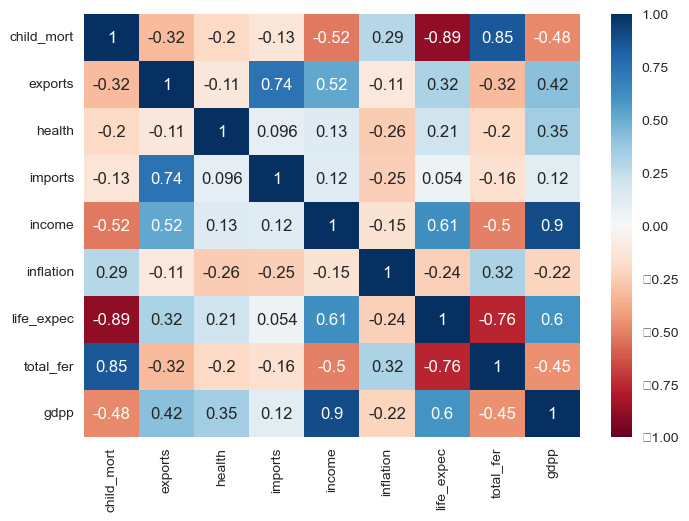

In [6]:
# correlation Heatmap
sns.heatmap(data.corr(numeric_only=True),annot=True,vmin=-1,cmap='RdBu')

# Visualize a data

In [7]:
# Before we begin visualization lets convert country to index (As it a redundant column)
data.set_index('country',inplace=True)
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090


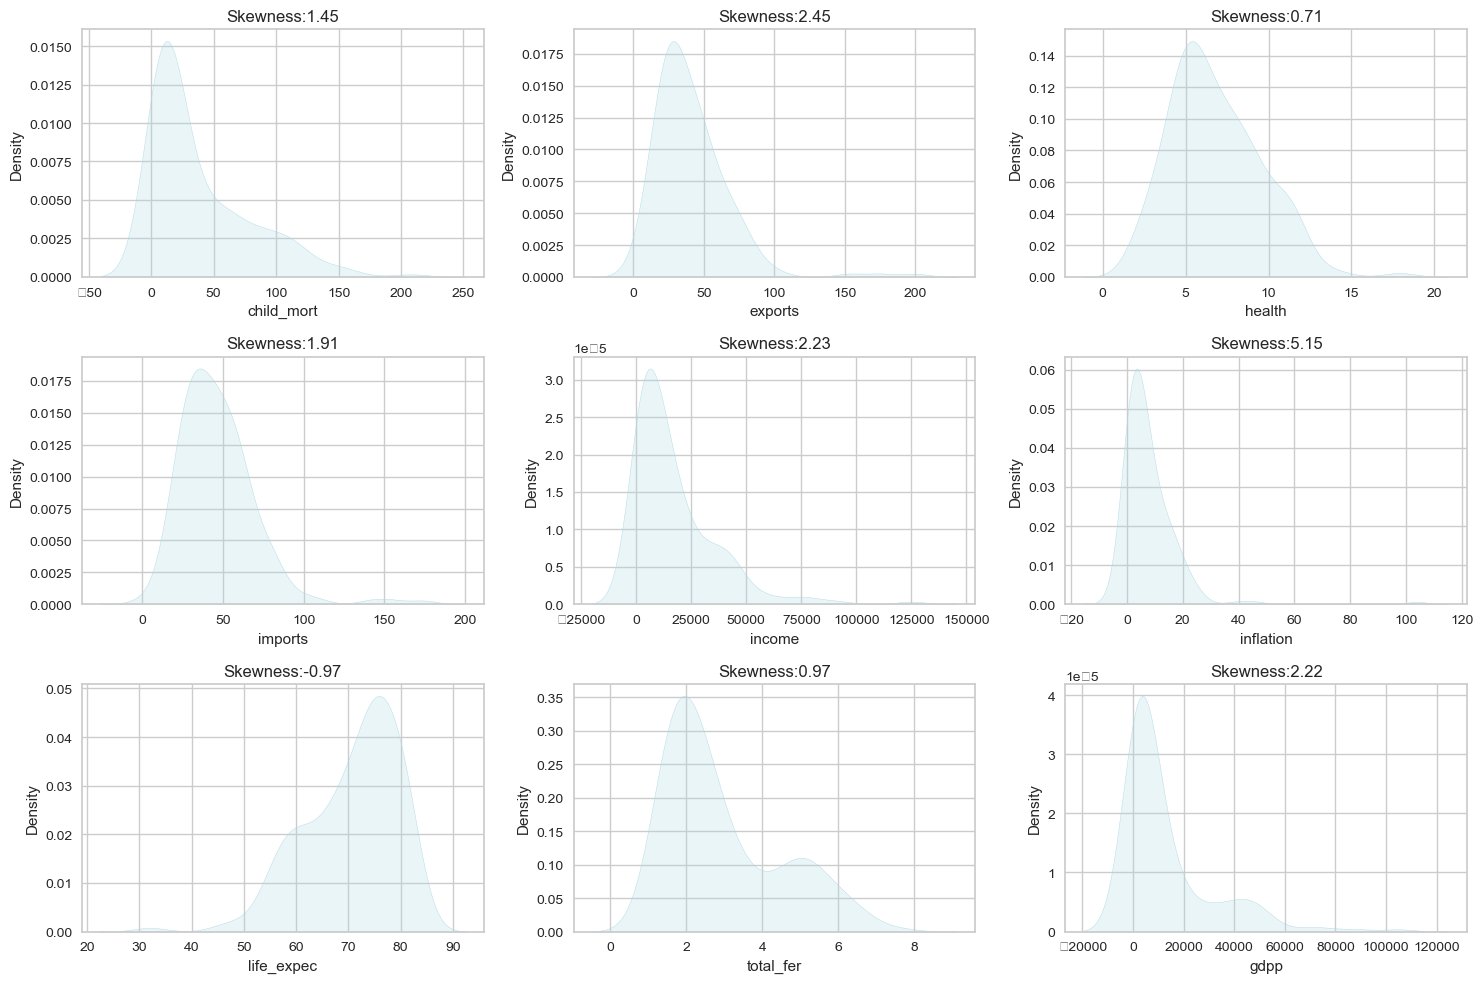

In [8]:
# Univariate anaylysis
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.kdeplot(data=data,x=i,fill=True,color='lightblue')
    skew=data[i].skew()
    kurt= data[i].kurt()
    plt.title(f'Skewness:{round(skew,2)}')
    t+=1
plt.tight_layout()
plt.show()

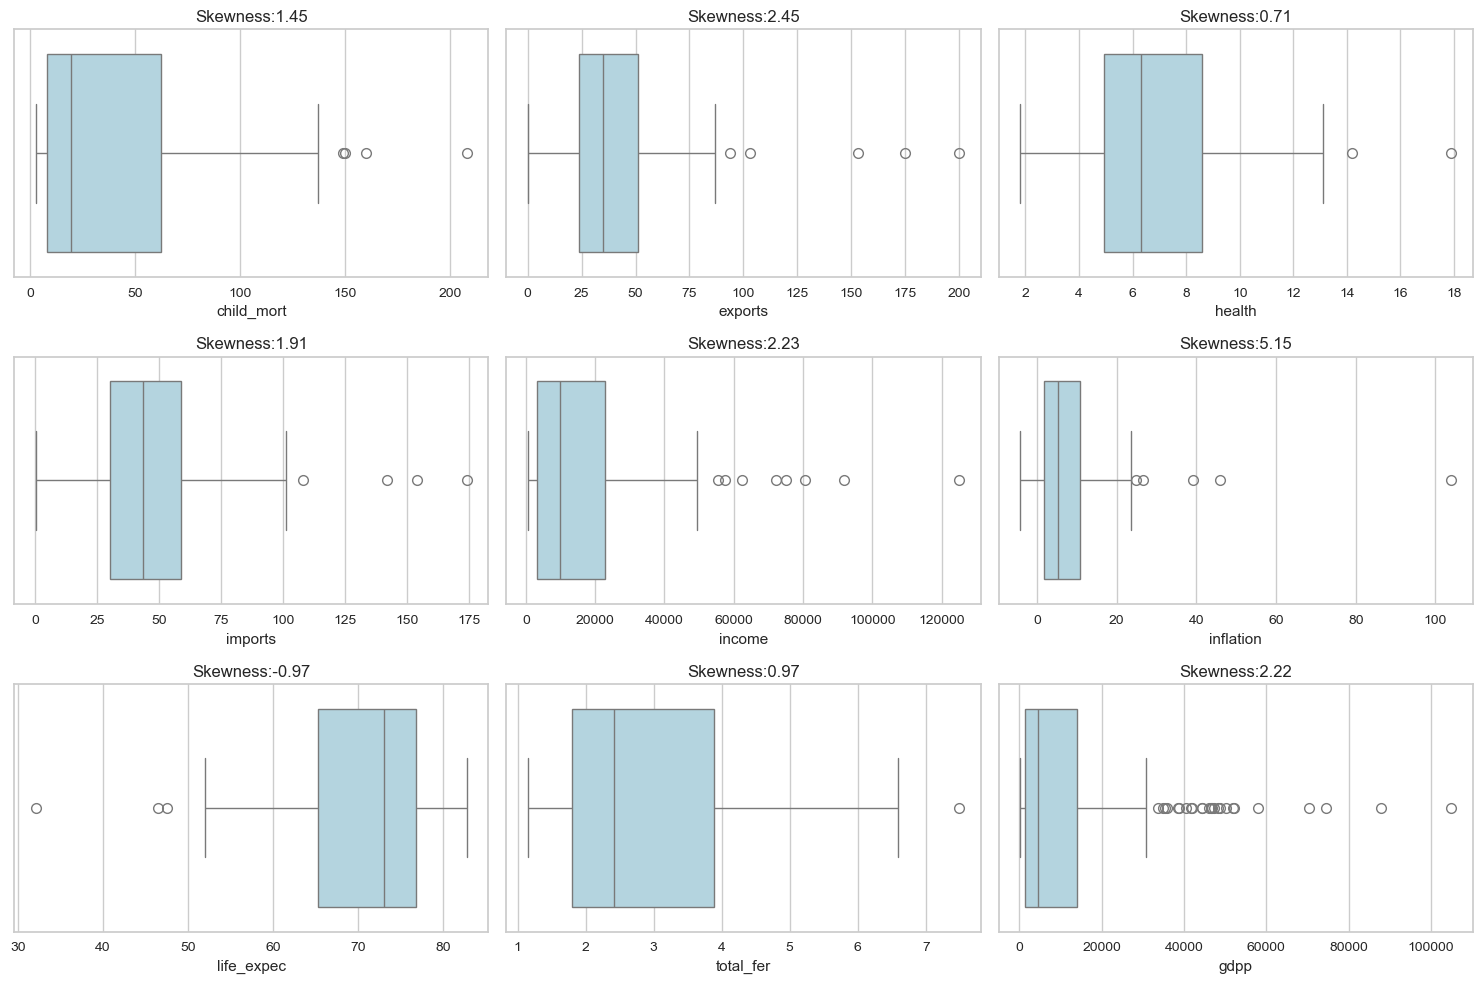

In [9]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='lightblue')
    skew=data[i].skew()
    kurt= data[i].kurt()
    plt.title(f'Skewness:{round(skew,2)}')
    t+=1
plt.tight_layout()

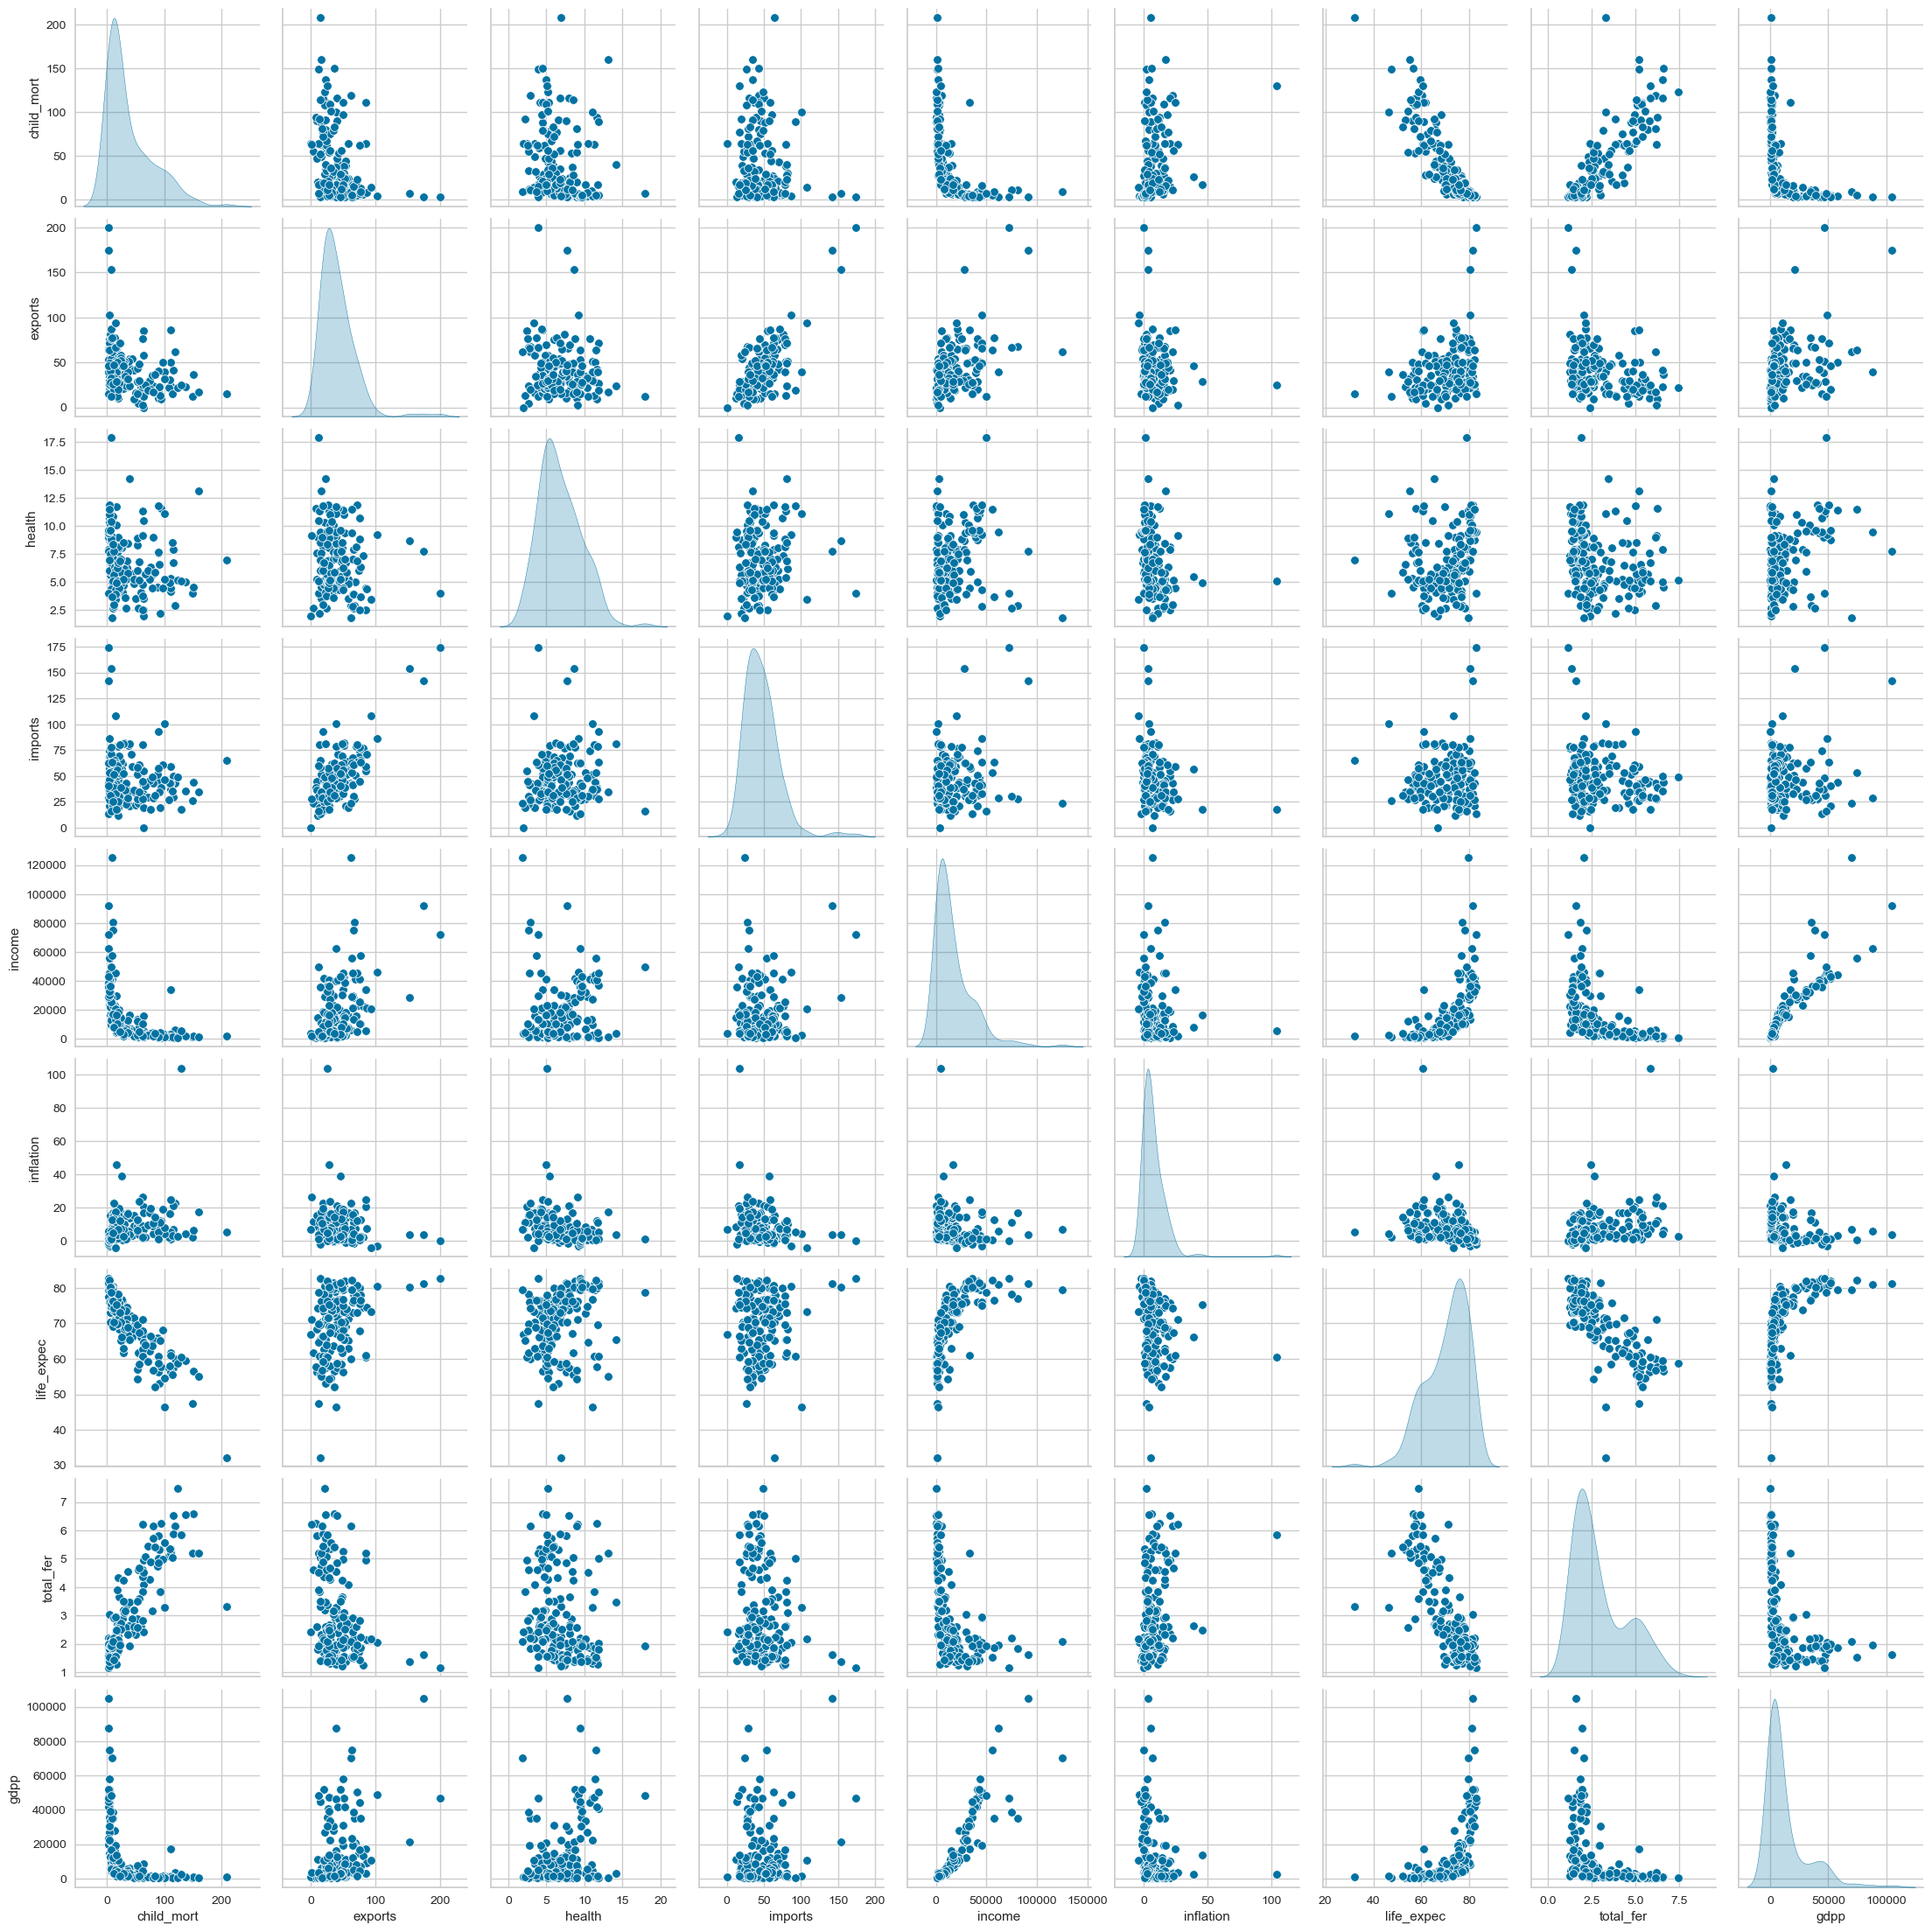

In [10]:
# Multivariate Anaylysis
sns.pairplot(data,diag_kind='kde')
plt.show()

# Data preprocessing

In [11]:
# Check for missing values
data.isnull().sum().sum()

# No missing values

np.int64(0)

In [12]:
# Lets treat the extreme oulliers using IQR method we will do capping
# In order to cap only the extreme once lets keep whisker length= 2.5

for i in data.columns:
    q1,q3 = np.quantile(data[i],[0.25,0.75])
    iqr=q3-q1
    ul,ll = q3+2.5*iqr,q1-2.5*iqr
    data[i] = data[i].apply(lambda x:ul if x>ul else ll if x<ll else x)

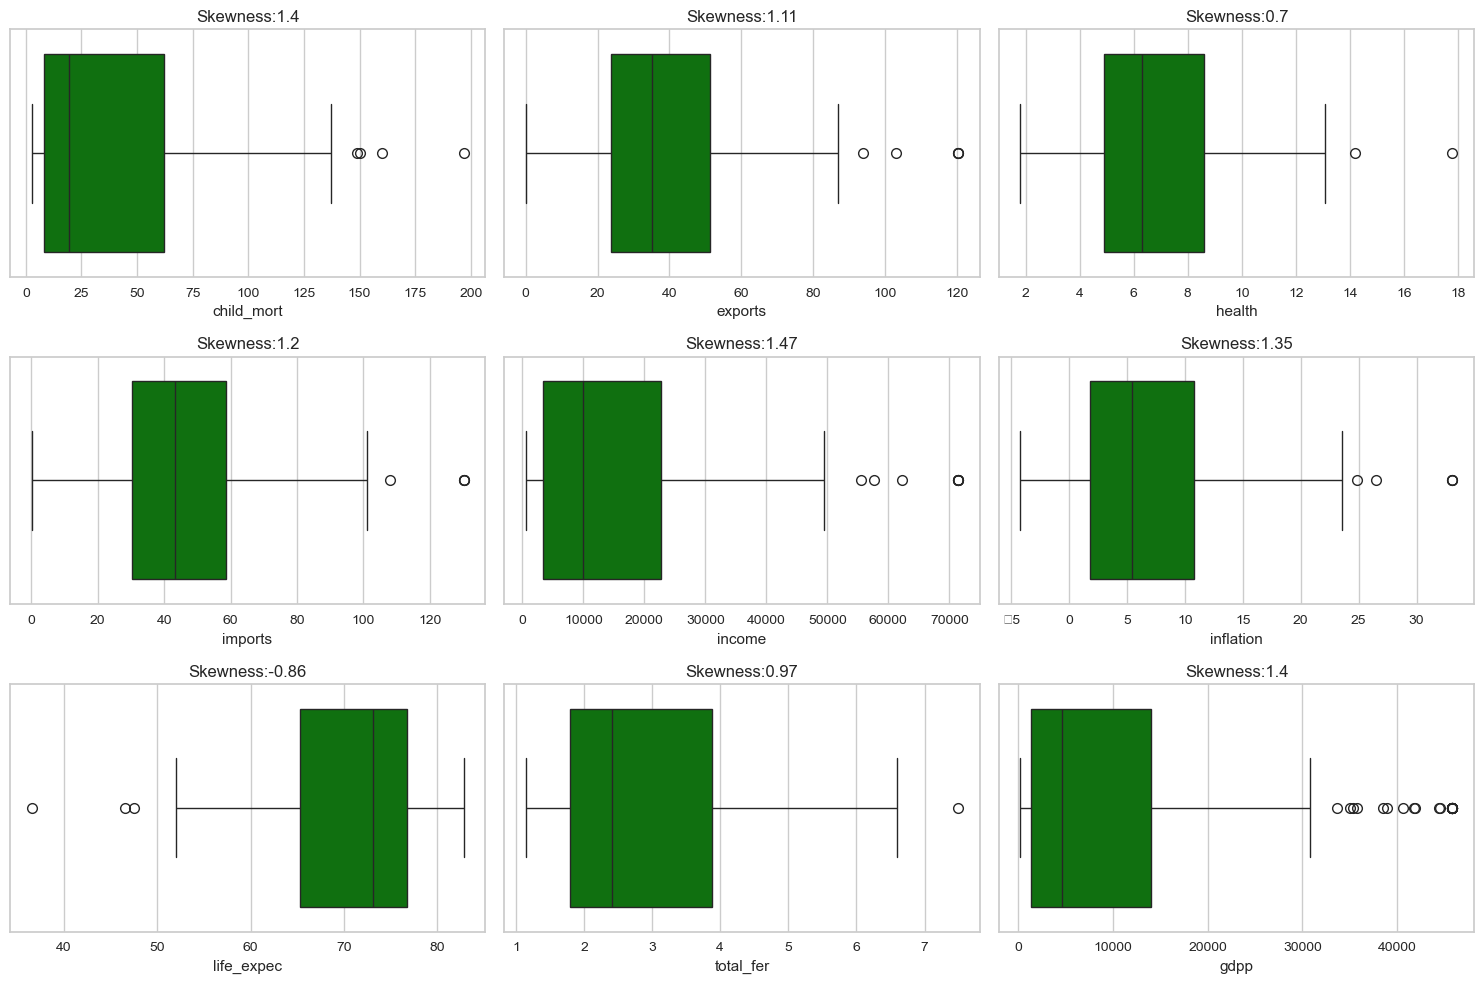

In [13]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    plt.subplot(3,3,t)
    sns.boxplot(data=data,x=i,fill=True,color='green')
    skew=data[i].skew()
    kurt= data[i].kurt()
    plt.title(f'Skewness:{round(skew,2)}')
    t+=1
plt.tight_layout()

In [14]:
# Lets apply PCA on the data before we procced with clustring.
# Just have better visualization and better clusturing.
# In PCA we need to pass standardized data. So lets import the function from the libraries

# Lets Create and instance of scalling
scaller = StandardScaler()

# Also lets Create an instance for PCA
pca = PCA(n_components=5,random_state=2)

# Lets Create Pipeline for the above two process
pipeline = Pipeline([('Scale',scaller),
                     ('PCA',pca)])



In [15]:
pipeline.fit(data)

Pipeline(steps=[('Scale', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=2))])

In [16]:
pca.explained_variance_ratio_.cumsum()

# At n_components = 5 we are able to explain ~ 95% variance , which is good enough.
# so 9-Dimension data can be reduced to 5-Dimension

array([0.4758564 , 0.64300208, 0.77845398, 0.88018006, 0.94647697])

In [17]:
final_data = pipeline.transform(data)

In [18]:
# Transform return the array. Lets convert it into dataframe
final_data = pd.DataFrame(final_data,columns=['PC1','PC2','PC3','PC4','PC5'],
                          index=data.index)
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5
country,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119


# K=Means Clustering

In [19]:
# Identify the value of k 
# Kelbow visualizer
kelbow = KElbowVisualizer(estimator=KMeans(random_state=2),k=10)

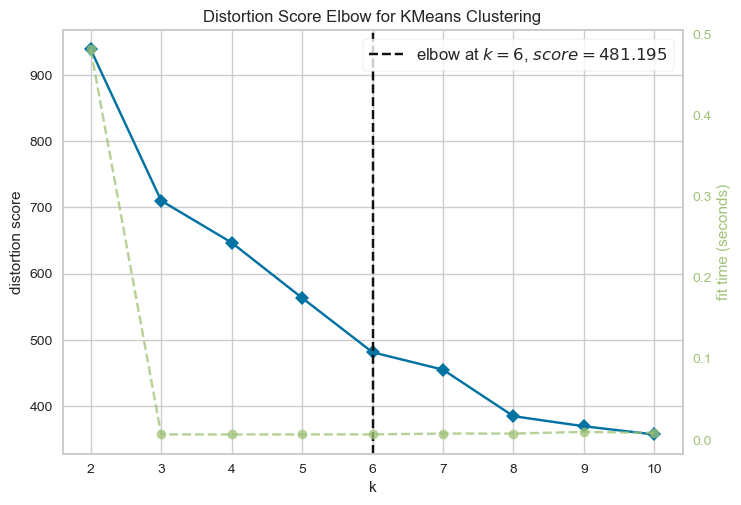

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
kelbow.fit(final_data)
kelbow.show()

 Although the above plot marks the elbow at k=6. But we can see the significant drop in 
 distortion score from k=2 to k=3 . As we increase the number of clusters it might become overfitted,
 Lets explore sillhouette visualizer to identify the correct or more generalised value to k.

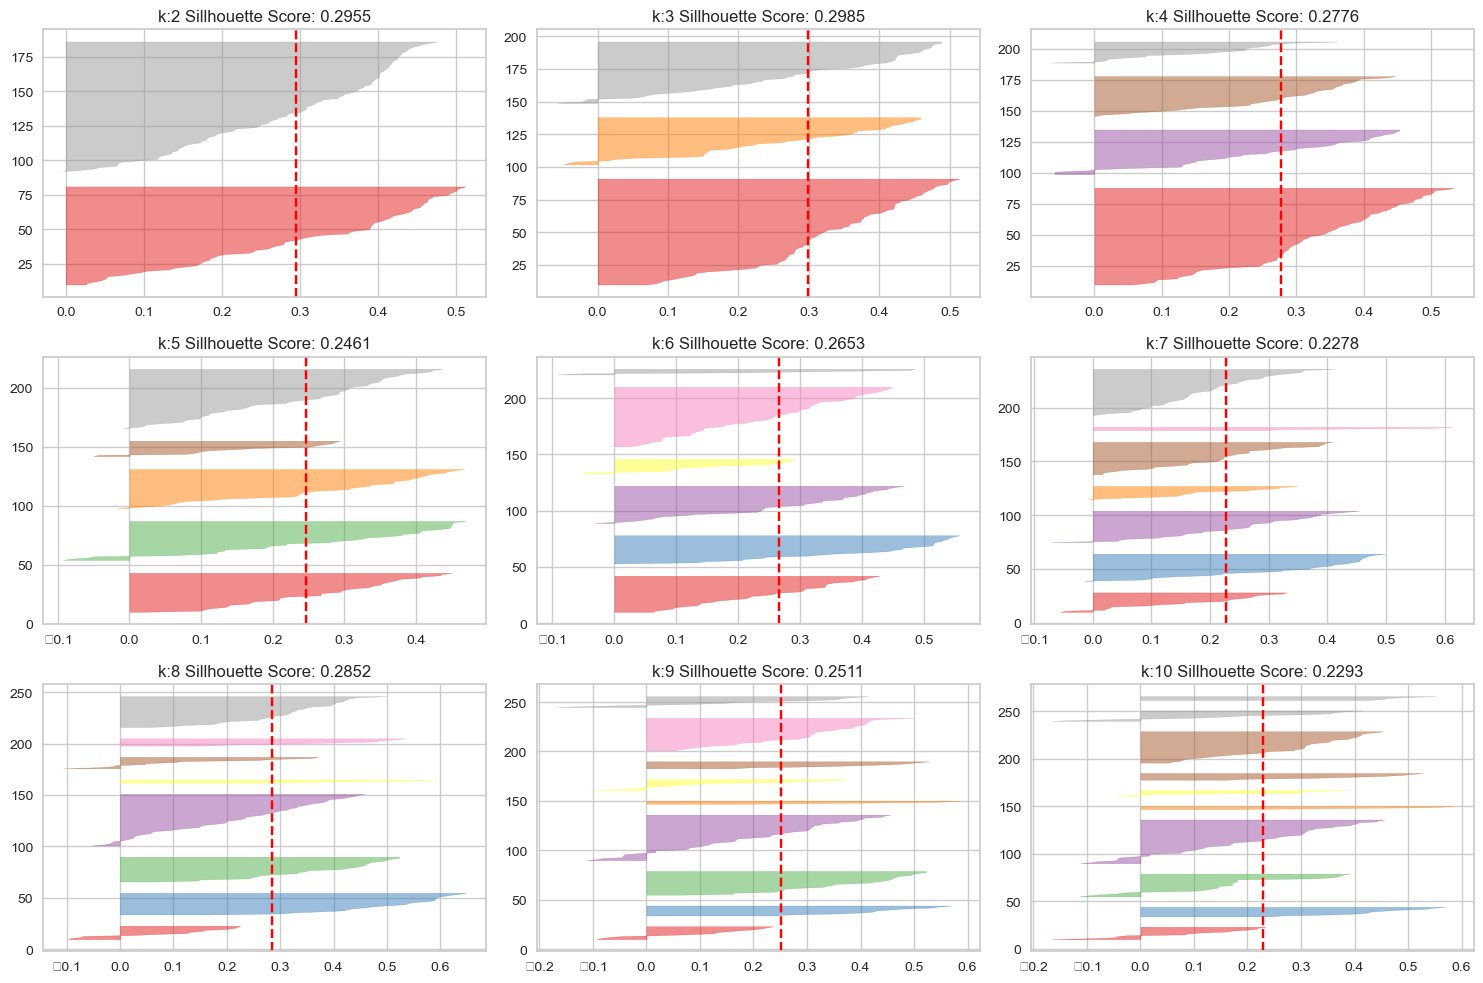

In [21]:
t=1
plt.figure(figsize=(15,10))
for i in range(2,11):
    plt.subplot(3,3,t)
    model= KMeans(n_clusters=i,random_state=2)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(final_data)
    plt.title(f'k:{i} Sillhouette Score: {round(sil_viz.silhouette_score_,4)}')
    t+=1
plt.tight_layout()
plt.show()

After analyzing Elbow plot and Silhouette Visualizer lets with k=3. Although there are few datapoints
that have been misclassified, But we see no drop in Silhouette Score and there is good enough data in every cluster. Also from k-elbow plot significant drop in WCSS (Distortion Score) was observed from k=2 to k=3.

In [22]:
final_kmeans = KMeans(n_clusters=3,random_state=2)

In [23]:
labels = final_kmeans.fit_predict(final_data)

In [24]:
# Lets check the sillhouette score
print('silhouette_score:',silhouette_score(final_data,labels))

silhouette_score: 0.29845782348296623


In [25]:
# Lets put these labeles on PCA Data
final_data['Labels'] = labels
final_data.head(3)

,PC1,PC2,PC3,PC4,PC5,Labels
country,,,,,,
Afghanistan,-3.043637,-0.201155,0.951322,0.793445,-0.006800,2
Albania,0.423415,-0.371463,0.171749,-1.353581,0.088623,0
Algeria,-0.404684,-0.440312,-1.636775,-0.573008,0.397119,0


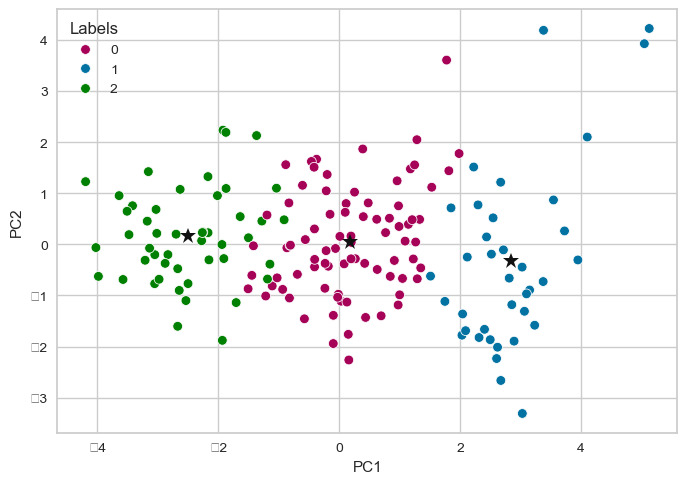

In [26]:
# Lets Visulize the clsuters
# In order get the best visualization lets choose PC1 and PC2 as they have maximum variance
centroids = final_kmeans.cluster_centers_
centroids

sns.scatterplot(data=final_data,x='PC1',y='PC2',palette=['m','b','green'],hue='Labels')
for i in range(3):
    plt.plot(centroids[i][0],centroids[i][1],marker='*',ms=12,color='k')
plt.show()

# Bussiness interpretation

In [27]:
# To have business understanding lets put the labels on origional dataset
data['Label']= labels
data.head(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Label
country,,,,,,,,,,
Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090.0,0


In [28]:
data.groupby(by='Label').mean()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Label,,,,,,,,,
0,21.508537,40.797317,6.231951,48.097561,12281.097561,7.474744,72.875610,2.311707,6291.146341
1,5.237838,53.575000,8.780270,49.129054,42690.878378,2.588432,79.956757,1.755676,36905.405405
2,92.131771,28.546229,6.296458,41.443040,3937.770833,10.438854,59.438542,4.953958,1902.916667


 After studying the above data we can conclude that countries that have been assigned in cluster 2 
can be called underdeveloped, While cluster 1 are developed. Countries belonging to cluster 0 are doing 
average in most of the factors but struggling in some economic factors like GDP/Income and expenditure on health. Hence they can be called developing.

In [29]:
data['Label'] = data['Label'].map({0:"Developing",
                   1:'Developed',
                   2:'Underdeveloped'})

In [30]:
# Developed Countries
data[data['Label']=='Developed'].index

Index(['Australia', 'Austria', 'Bahamas', 'Bahrain', 'Belgium', 'Brunei',
       'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Kuwait', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway',
       'Portugal', 'Qatar', 'Singapore', 'Slovak Republic', 'Slovenia',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United Kingdom', 'United States'],
      dtype='object', name='country')

In [31]:
# Developing Countries
data[data['Label']=='Developing'].index

Index(['Albania', 'Algeria', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bangladesh', 'Barbados', 'Belarus', 'Belize', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cambodia',
       'Cape Verde', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia',
       'Fiji', 'Georgia', 'Grenada', 'Guatemala', 'Guyana', 'Hungary', 'India',
       'Indonesia', 'Iran', 'Jamaica', 'Jordan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lebanon', 'Libya', 'Lithuania',
       'Macedonia, FYR', 'Malaysia', 'Maldives', 'Mauritius',
       'Micronesia, Fed. Sts.', 'Moldova', 'Mongolia', 'Montenegro', 'Morocco',
       'Nepal', 'Oman', 'Panama', 'Paraguay', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russia', 'Samoa', 'Saudi Arabia', 'Serbia', 'Seychelles',
       'Solomon Islands', 'Sri Lanka', 'St. Vincent and the Grenadines',
       'Suriname', 'Tajikistan', '

In [32]:
# Underdeveloped Countries
data[data['Label']=='Underdeveloped'].index

Index(['Afghanistan', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Cote d'Ivoire', 'Equatorial Guinea',
       'Eritrea', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
       'Haiti', 'Iraq', 'Kenya', 'Kiribati', 'Lao', 'Lesotho', 'Liberia',
       'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar',
       'Namibia', 'Niger', 'Nigeria', 'Pakistan', 'Rwanda', 'Senegal',
       'Sierra Leone', 'South Africa', 'Sudan', 'Tanzania', 'Timor-Leste',
       'Togo', 'Uganda', 'Yemen', 'Zambia'],
      dtype='object', name='country')

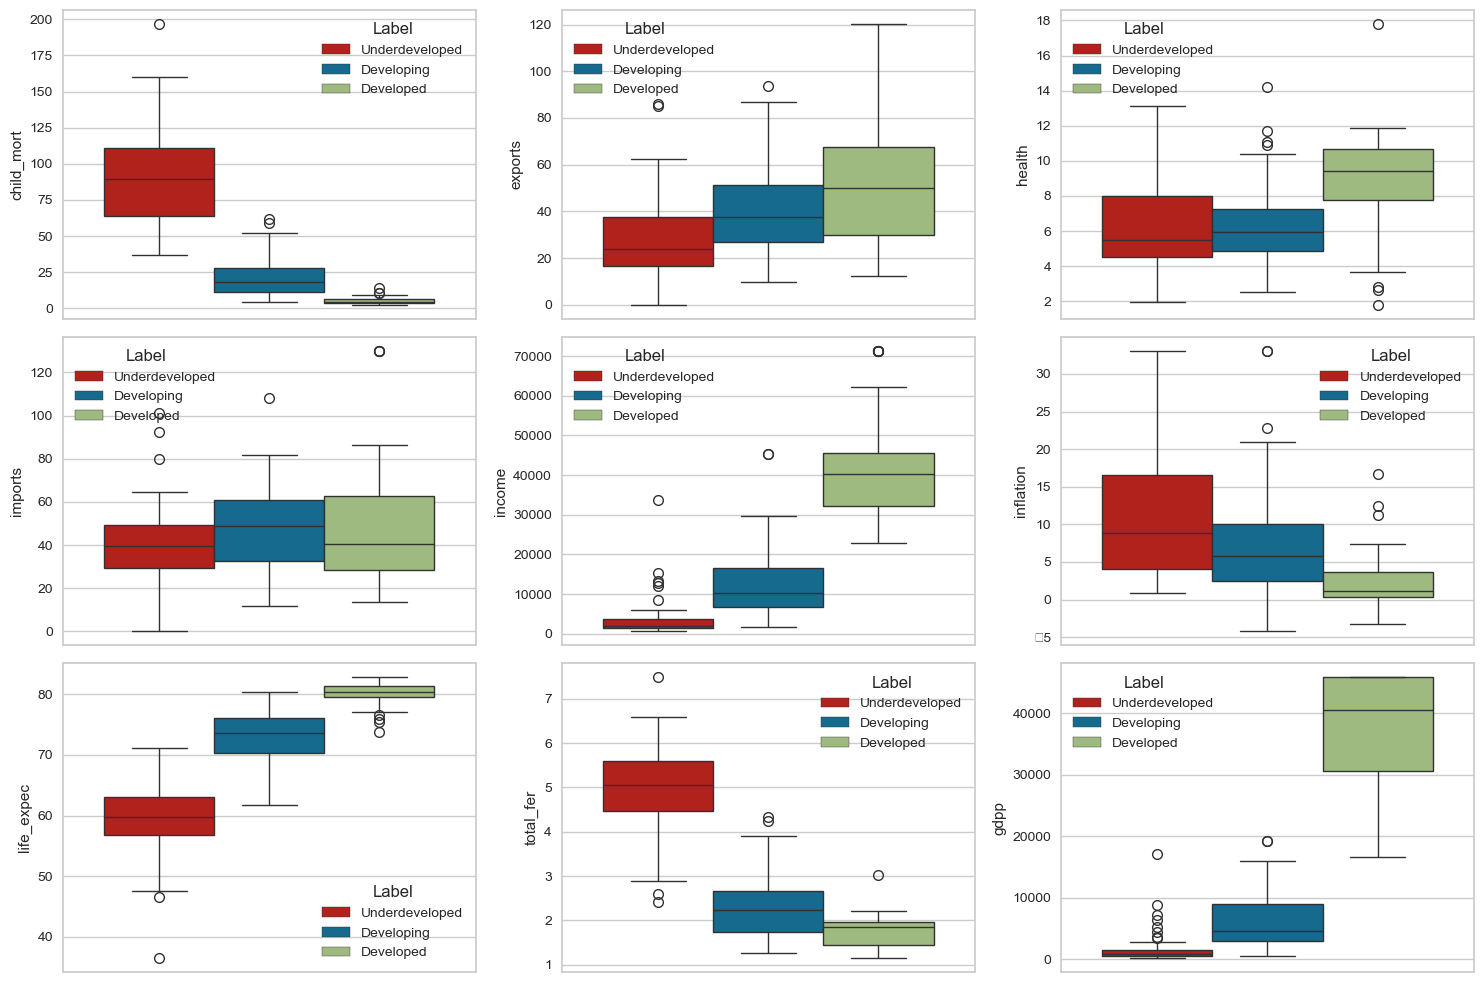

In [33]:
t=1
plt.figure(figsize=(15,10))
for i in data.columns:
    if i != 'Label':
        plt.subplot(3,3,t)
        sns.boxplot(data=data,y=i,hue='Label',palette=['r','b','g'])
        t+=1
plt.tight_layout()
plt.show()

In [34]:
# World Map
px.choropleth(data_frame=data,locationmode='country names',
              locations=data.index, color='Label',
              color_discrete_map={'Underdeveloped':'red',
                                  'Developing':'blue',
                                  'Developed':'green'})

# Deployment

In [35]:
input_data = data.iloc[0,:-1].values
input_data

array([np.float64(90.2), np.float64(10.0), np.float64(7.58),
       np.float64(44.9), np.float64(1610.0), np.float64(9.44),
       np.float64(56.2), np.float64(5.82), np.float64(553.0)],
      dtype=object)

In [36]:
final_input_data = pipeline.transform([input_data])
final_input_data

array([[-3.04363665, -0.20115529,  0.95132235,  0.79344472, -0.00680001]])

In [37]:
final_kmeans.predict(final_input_data)[0]

np.int32(2)

In [40]:
# Lets create a joblib file of pipeline
with open('Pipeline.joblib','wb') as file:
    joblib.dump(pipeline,file)

In [41]:
# Lets create a joblib file of model
with open('model.joblib','wb') as file:
    joblib.dump(final_kmeans,file)